<a href="https://colab.research.google.com/github/arunt-sjsu/deep_learning/blob/main/Assignment4/Pytorch_with_auto_differentiation_primitives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The Goal of this notebook is to demonstrate pytorch based linear regression to predict 'a' from the dummy data. This notebook does uses auto differentiation primitives and the results are eventually plotted**


In [30]:
%matplotlib inline
import numpy as np
import torch
from torch.autograd import Variable
import pandas as pd
torch.set_printoptions(edgeitems=2, linewidth=75)

In [4]:
df = pd.DataFrame(np.random.randn(10000, 3)*10, columns=list('xyz'))
weights = pd.DataFrame(np.random.randn(10000,1), columns=['weights_a'])
weights['weights_b'] = np.random.randn(10000,1)
weights['weights_c'] = np.random.randn(10000,1)

In [5]:
df["a"] = 2 * weights['weights_a'] * np.square(df['x']) + 8 * weights['weights_b'] * np.power(df['y'],3) - 3 * df['z'] 
df["b"] = 3 * weights['weights_a'] * np.square(df['x']) - 5 * weights['weights_b'] * np.square(df['y']) - 2 * weights['weights_c'] * np.power(df['z'],3) 

In [6]:
bin_labels = ['Low', 'Mid', 'High', 'Very High']
df['Level_A'] = pd.qcut(df['a'], q=4, labels=bin_labels)
df['Level_B'] = pd.qcut(df['b'], q=4, labels=bin_labels)


In [21]:
t_c = torch.tensor(df["a"])
t_u = torch.tensor(df["x"])
t_v = torch.tensor(df["y"])
t_w = torch.tensor(df["z"])
t_un = 0.1 * t_u
t_vn = 0.1 * t_v
t_wn = 0.1 * t_w

In [22]:
def model(t_u,t_v,t_w, w1 ,w2 ,w3, b):
    return w1 * t_u + w2 * t_v + w3 * t_w + b

In [23]:
def loss_fn(t_p, t_c):
    squared_diffs = Va(t_p - t_c)**2
    return squared_diffs.mean()

In [24]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [25]:
params = torch.tensor([1.0,1.0,1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [31]:
w1 = torch.ones(())
w2 = torch.ones(())
w3 = torch.ones(())
b = torch.zeros(())

t_p = model(t_u,t_v,t_w, w1 ,w2 ,w3, b)

loss = Variable(loss_fn(t_p, t_c), requires_grad = True)
loss.backward()

optimizer.step()

params

tensor([1., 1., 1., 0.], requires_grad=True)

In [33]:
params = torch.tensor([1.0,1.0,1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u,t_v,t_w, w1 ,w2 ,w3, b)
loss = Variable(loss_fn(t_p, t_c), requires_grad = True)

optimizer.zero_grad() # <1>
loss.backward()
optimizer.step()

params

tensor([1., 1., 1., 0.], requires_grad=True)

In [36]:
def training_loop(n_epochs, optimizer, params,  t_u,t_v,t_w, t_c):
    for epoch in range(1, n_epochs + 1):
      w1,w2,w3, b = params
      t_p = model(t_u,t_v,t_w, w1 ,w2 ,w3, b)
      loss = loss_fn(t_p, t_c)
        
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch % 500 == 0:
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [38]:
params = torch.tensor([1.0,1.0,1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_v = t_vn,
    t_w = t_wn,
    t_c = t_c)

Epoch 500, Loss 791348308.293187
Epoch 1000, Loss 791348308.281718
Epoch 1500, Loss 791348308.281718
Epoch 2000, Loss 791348308.281718
Epoch 2500, Loss 791348308.281718
Epoch 3000, Loss 791348308.281718
Epoch 3500, Loss 791348308.281718
Epoch 4000, Loss 791348308.281718
Epoch 4500, Loss 791348308.281718
Epoch 5000, Loss 791348308.281718


tensor([ 384.3183, 2255.9260,  106.2089,  -69.7810], requires_grad=True)

In [40]:
params = torch.tensor([1.0,1.0,1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 2000, 
    optimizer = optimizer,
    params = params, 
    t_u = t_u, 
    t_v = t_v, 
    t_w = t_w, 
    t_c = t_c)

Epoch 500, Loss 794456882.287282
Epoch 1000, Loss 793154206.754855
Epoch 1500, Loss 792307899.915300
Epoch 2000, Loss 791799266.543073


tensor([ 38.3066, 158.0980,  10.6942, -77.2065], requires_grad=True)

In [41]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices  # <1>

(tensor([8408, 6447,  ...,  791, 9913]),
 tensor([4458, 5702,  ..., 6559, 9523]))

In [42]:
train_t_u = t_u[train_indices]
train_t_v = t_v[train_indices]
train_t_w = t_w[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_v = t_v[val_indices]
val_t_w = t_w[val_indices]
val_t_c = t_c[val_indices]

In [43]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_v, val_t_v,
                  train_t_w, val_t_w,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u,train_t_v, train_t_w,  *params)
        train_loss = loss_fn(train_t_p, train_t_c)
                             
        val_t_p = model(val_t_u, val_t_v, val_t_w, *params) # <1>
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward() # <2>
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
            
    return params

In [47]:
params = torch.tensor([1.0,1.0,1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 1000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_u,  
    val_t_u = val_t_u, 
    train_t_v = train_t_v,  
    val_t_v = val_t_v, 
    train_t_w = train_t_w,  
    val_t_w = val_t_w, 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 784069871.2835, Validation loss 846163619.4170
Epoch 2, Training loss 783854168.7692, Validation loss 864916334.7080
Epoch 3, Training loss 783648497.7165, Validation loss 846087321.3424
Epoch 500, Training loss 66368545160876711936.0000, Validation loss 64524931872558784512.0000
Epoch 1000, Training loss 19299226125442052373222334840963072.0000, Validation loss 18763124391034684638428554015539200.0000


tensor([-1.2660e+16, -7.9494e+14, -6.4756e+15, -2.9895e+13],
       requires_grad=True)

In [51]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_v, val_t_v, train_t_w, val_t_w,
                  train_t_c, val_t_c):
                  for epoch in range(1, n_epochs + 1):
                    train_t_p = model(train_t_u,train_t_v, train_t_w,  *params)
                    train_loss = loss_fn(train_t_p, train_t_c)
                                        
                    with torch.no_grad(): # <1>
                        val_t_p = model(val_t_u, val_t_v, val_t_w, *params) # <1>
                        val_loss = loss_fn(val_t_p, val_t_c)
                        assert val_loss.requires_grad == False # <2>
                        
                    optimizer.zero_grad()
                    train_loss.backward()
                    optimizer.step()

In [52]:
def calc_forward(t_u,t_v,t_w, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u,t_v,t_w, t_c, *params)
        loss = loss_fn(t_p, t_c)
    return loss

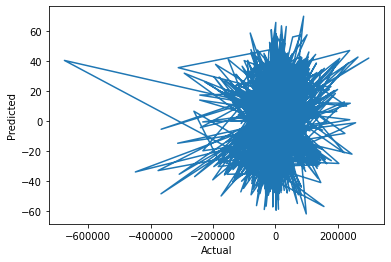

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_u,t_v,t_w, w1 ,w2 ,w3, b)

fig = plt.figure()
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(t_c.numpy(), t_p.detach().numpy())